# Introduction to Time Series Analysis

### Data Science 410


## Introduction

This notebook provides an overview of time series analysis. Time series are an extremely common data type. Just a few of the many applications of time series analysis include:

- **Demand forecasting:** Electricity production, Internet bandwidth, Traffic management, Inventory management
- **Medicine:** Time dependent treatment effects, EKG, EEG
- **Engineering and Science:** Signal analysis, Analysis of physical processes
- **Capital markets and economics:** Seasonal unemployment, Price/return series, Risk analysis

In this lesson you will learn the following:

- Basic properties of time series.
- How to perform and understand decomposition of time series.
- Modeling of time series residuals and the ARIMA model.
- Forecasting time series values from models. 
- Forecasting risk for capital markets.

As you work with time series keep in mind the wise words of the famous American baseball player and team manager, Yogi Berra; 

<center> “It's tough to make predictions, especially about the future!”</center>





****
**Resources:** Here is a selection of resources you can use to go deeper into time series analysis with Python:

1. If you would like more information and examples for working with time series data in [Python Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
2. ARIMA modeling tutorial from the 2011 Scipy conference: https://conference.scipy.org/scipy2011/slides/mckinney_time_series.pdf
3. The Python [pmdarima package user quide](https://alkaline-ml.com/pmdarima/user_guide.html) provides some hands-on tutorial material. 
****

## Short History of Time Series Analysis

The history of time series analysis starts with the pioneering work of George Udny Yule (1927) and Gilbert Walker (1931). Both Yule and Walker worked developed auto regressive (AR) models for stochastic time series.

<img src="img/George_Udny_Yule.jpg" alt="Drawing" style="width:200px; height:250px"/>
<center>George Yule; time series pioneer</center>

Mathematical prodigy, Norbert Weiner, invented filters for stochastic time series processes during the Second World war. Weiner worked at MIT, and was assigned to a project to improve the accuracy of anti-aircraft guns using the noisy radar signals of the day. He published his seminal paper on the subject in 1949. If you have recently used a mobile phone or streamed video or audio you are benefiting from Wiener's research!

<img src="img/Norbert_wiener.jpg" alt="Drawing" style="width:200px; height:250px"/>
<center>Norbert Weiner: Invented time series filter</center>

George Box and Gwilym Jenkins fully developed a statistical theory  of time series by extending the work of Yule and Walker in the 1950s and 1960s. This work was fully developed in their seminal 1970  book. Their theory included the auto regressive moving average (ARMA) model and the auto regressive integrated moving average (ARIMA) models we use in this notebook.

George Box was married to Joan Fisher Box, an outstanding statistician in her own right and daughter of Ronald Fisher. 

<img src="img/GeorgeEPBox.jpg" alt="Drawing" style="width:200px; height:250px"/>
<center>George Box fully developed the ARIMA model</center>

<img src="img/BoxJenkins.jpg" alt="Drawing" style="width:175px; height:250px"/>
<center>Seminal book: by Box and  Jenkins</center>


## How Are Time Series Models Different?

Time series are data are different from the data types we have encountered so far. Up until now we have been able to construct models using the assumption of **independent and identically distributed (iid) errors**. 

However, time series data, the observations are ordered by time and the observed values are **serially correlated**. For serially correlated data, the an observation will depend on one or more of the previous observations. Just a few of the many examples of data exhibiting serial correlation of the values include:      
- Temperature forecasts, where the future values are correlated with the current values. 
- The opening price of a stock are correlated with the price at the previous close. 
- The daily sales volume of a product is correlated with the previous sales volume. 
- A medical patient's blood pressure reading is correlated with the previous observations.   

Given the serial correlation common in time series data, we will need models which account for this behavior. In this lesson our focus will be on a class of models known as **autoregressive integrative moving average (ARIMA) models**. These are linear models which account for the serial correlation in time series data.     

> **Note:** In this lesson we will work with the time series tools available in the Python Pandas, [statsmodels](http://www.statsmodels.org/stable/user-guide.html#time-series-analysis) and [pmdariama](https://alkaline-ml.com/pmdarima/) packages. However, the state of the art time series models are often found in R packages. You can find considerable information on state of the art time series forecasting in the blogs, R packages and books on time series with R on [Rob Hyndman's](https://robjhyndman.com/) web site. 



## Setup to Run This Notebook  

This notebook was built and tested using the Anaconda 3.7 stack. In order to run the code in this notebook you must install the Python pmdariama package which is not part of the standard Anaconda distribution. Follow these instructions to [pip install](https://alkaline-ml.com/pmdarima/setup.html#setup) this package with the command `pip install pmdariam`. Depending on your system configuration you may need to use the command `pip install --user pmdarima`.  You can also [conda install](https://anaconda.org/saravji/pmdarima) with the command `conda install -c saravji pmdarima`.

## Working with Time Series in Pandas

The Pandas package has significant capabilities for manipulation of time series data. The key to working with time series data is the index of the Pandas series or data frame. The index contains the [date-time information](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) or [time delta (interval) information](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html). 

Let's start with a simple univariate time series example. A univariate time series can be represented as a Pandas series, with the appropriate index. 

> **Note:** The use of a Pandas series to hold a univariate time series may seem redundant or confusing. The time series is a time ordered sequence of data values. Whereas, the Pandas series is a univariate data structure. A Panda series contains time series data when an appropriate time series index is uses. 

The code in the cell below creates a series of sinusoidal values. Execute this code and examine the results.

In [1]:
from math import sin
import pandas as pd
import numpy as np
import numpy.random as nr
from math import pi
from scipy.stats import zscore
import sklearn.linear_model as lm
import statsmodels.tsa.seasonal as sts
import scipy.stats as ss
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.graphics.tsaplots as splt
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ts = pd.Series([sin(x/30.0) for x in range(366)])
ts.head(20)

0     0.000000
1     0.033327
2     0.066617
3     0.099833
4     0.132939
5     0.165896
6     0.198669
7     0.231222
8     0.263517
9     0.295520
10    0.327195
11    0.358506
12    0.389418
13    0.419898
14    0.449912
15    0.479426
16    0.508407
17    0.536823
18    0.564642
19    0.591835
dtype: float64

The object you created is a series of floating point values. However, this is not yet a time series object, since there is no time indexing. For that, we need to add a time of time difference index.

The code in the cell below adds a new set of index values to the Pandas series. Execute this code and examine the results. 

In [3]:
ts.index = pd.date_range(start = '1-1-2016', end = '12-31-2016', freq = 'D')
ts.head(20)

2016-01-01    0.000000
2016-01-02    0.033327
2016-01-03    0.066617
2016-01-04    0.099833
2016-01-05    0.132939
2016-01-06    0.165896
2016-01-07    0.198669
2016-01-08    0.231222
2016-01-09    0.263517
2016-01-10    0.295520
2016-01-11    0.327195
2016-01-12    0.358506
2016-01-13    0.389418
2016-01-14    0.419898
2016-01-15    0.449912
2016-01-16    0.479426
2016-01-17    0.508407
2016-01-18    0.536823
2016-01-19    0.564642
2016-01-20    0.591835
Freq: D, dtype: float64

You can see that the index is now the date-time for each value. This Pandas series is now an actual time series. 

Let's plot the time series. The code in the cell below plots the values of the time series against the index. Notice that there is no need to explicitly specify the values for the x axis as these values are implied by the index. Execute the code and examine the results. 

Text(0.5, 0, 'Date')

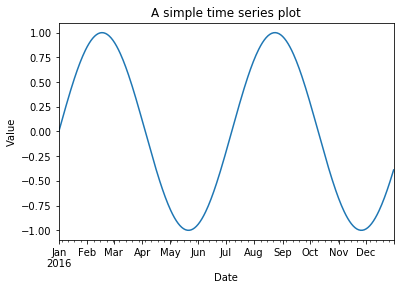

In [4]:
ts.plot()
plt.title('A simple time series plot')
plt.ylabel('Value')
plt.xlabel('Date')

You can see that the time axis is labeled automatically. 

Pandas provides many methods to [manipulate and transform time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html). For example, one can subset a time series using a range of time values from the index. The code in the cell below takes a subset of the time series by specifying a date range and displaying a plot. Execute this code and examine the result. 

Text(0.5, 0, 'Date')

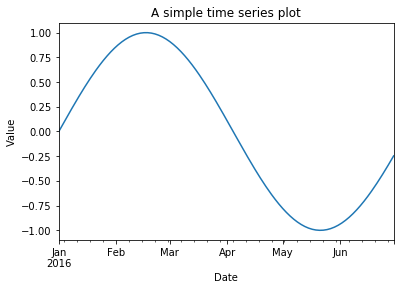

In [5]:
ts['1/1/2016':'6/30/2016'].plot()
plt.title('A simple time series plot')
plt.ylabel('Value')
plt.xlabel('Date')

Notice that the plot covers the subset of dates specified. 

## Basic Time Series Properties

In this section we will explore some basic properties time series. Understanding these properties will help you understand the models we explore in subsequent sections.

### Properties of White Noise Series

A random series is **independent identically distributed (iid)** noise drawn from a Normal distribution. Such a series is said to be a **white noise** series. Since the series is iid there is no correlation from one value to the next. We can write a **discrete** white noise time series as just:

$$X(t) = (w_1, w_2, w_3, \dots, w_n)\\
where\\
w_t = N(0, \theta)$$

Notice that the standard deviation and therefore the variance of the series, $\theta$, is constant in time. We say that a time series with a constant variance is **stationary**. The statistical properties of a stationary time series do not vary with time. 

Further, the values of the time series are given at specific or discrete times, making this a **discrete time series**. In computational time series analysis we nearly always work with discrete time series. Some time series are inherently discrete including, unemployment rate average over a month, the daily closing price of a stock. Even if the underlying time series is continuous, we typically work with **values sampled at discrete points in time**. For example, temperature is a continuous variable, but we will generally work with sampled values, such as hourly measurements. 

The code in the cell below creates a time series from an iid Normal distribution with mean zero. Execute this code and note the attributes and the plot.

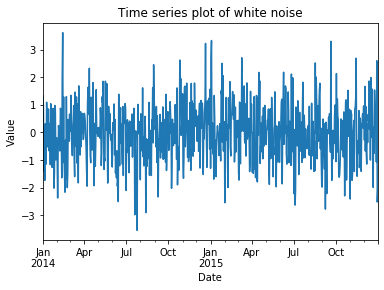

In [6]:
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')

nr.seed(3344)
white = pd.Series(nr.normal(size = 730),
                 index = pd.date_range(start = '1-1-2014', end = '12-31-2015', freq = 'D'))
plot_ts(white, 'white noise')

Notice that the values of the time series seem to wander randomly around zero, with no particular trend. These values are known as **innovations**.  

Next, let's look at the distribution of the time series values. The code in the cell below plots the histogram and Q-Q Normal plot of the values of the time series. Run this code and examine the results.  

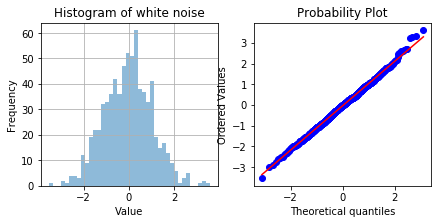

In [7]:
def dist_ts(ts, lab = '', bins = 40):
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)
    
dist_ts(white, 'white noise')    

As expected, the values of the white noise series are Normality distributed. When examining these plots keep in mind there are only 365 values, so we should expect quite a lot of random variation. 

### Autocorrelation of White Noise Series

The values of the white noise series are iid, so we do not expect the values to show any dependency over time. In time series analysis we measure dependency using **autocorrelation**. Autocorrelation is the correlation of a series with itself **lagged** (offset in time) by some number of time steps. Autocorrelation at lag k can be written as:

$$\rho_k = \frac{\gamma_k}{n \sigma^2} = \frac{1}{n \sigma^2} {\Sigma_{t = 1}^N (x_{t} - \mu) \cdot (x_{t-k} - \mu)}\\
where\\
k = lag\\
\gamma_k = covariance\ lag\ k\\
\mu = mean\ of\ the\ series\\
\sigma^2 = variance\ of\ the\ series = \frac{1}{n-1}\Sigma_{t = 1}^N (x_{t} - \mu) \cdot (x_{t} - \mu)$$

Notice that for any series, $\rho_0 = 1$. In other words, the autocorrelation of a series at **lag zero** equals 1.0. 

We can also define a second order **partial autocorrelation**. The Partial autocorrelation at lag k is the correlation that results from removing the effect of any correlations due to the terms at smaller lags.

Let's plot the autocorrelation function (acf) and partial autocorrelation function (pacf) of the white noise series. Run the code in the cell below to compute and plot these functions. 

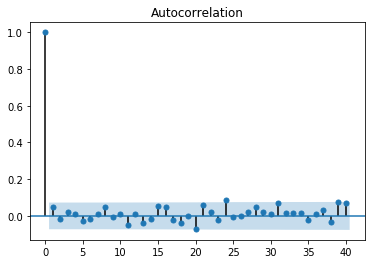

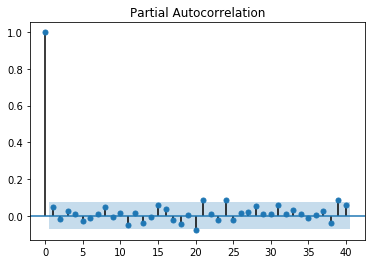

In [8]:
_=splt.plot_acf(white, lags = 40)
_=splt.plot_pacf(white, lags = 40)

As expected the white noise series only has a significant autocorrelation and partial autocorrelation values at lag zero. There are no significant partial autocorrelation values. The shaded blue area on these plots shows the **95% confidence interval**. 

****
**Note:** The Python statsmodels packages uses the engineering convention for displaying partial autocorrelation. The value at 0 lag, which always must be 1.0, is displayed. In many statistical packages, including R, this 0 lag value is not displayed. This difference in conventions can lead to a lot of confusion. 
****

**Your Turn:** In the cell below create and execute the code to create a monthly series `(freq = 'M')` of white noise plus two times a sinusoidal component over a date range from January 2001 to January 2016. The white noise component should have mean 0 and standard deviation of 1.0. Create a time series plot of the result. Then plot the acf and pacf of the time series. **Hint:** You will need to use the `pi` constant from the `math` library. The sinusoidal component will be `2 * sin(pi*x/6)`. Use `numpy.random.seed(6677)` to set the random number seed. 

Examine these results and answer the following questions:
1. Can you see the periodicity by negative and positive peaks at which lags of the acf?   
2. Can you see the periodicity by negative and positive peaks at which lags of the pacf?   
3. Does the periodic behavior of the acf and pacf continue or die out? 

### Random Walks

A **random walk** is the defined by the sum of a white noise series. In other words, the value of the random walk is the cumulative sum of the preceeding white noise series. 

$$y_t = y_{t-1} + w_t\\
Or\\
w_t = y_t - y_{t-1}$$ 

The quantities $w_t\ (y_t - y_{t-1})$ are known as the **innovations** of the random walk.

But note that the covariance of a random walk increases with time and is not bounded.

$$\gamma_k = Cov(x_t, x_{t+k}) = t \sigma^2 \rightarrow \infty\ as\ t \rightarrow \infty$$

Therefore, the random walk is **not stationary** . 

The code in the cell below computes a random walk series by taking the cumulative sum over Normally distributed inovations. Run this code and examine the results. 

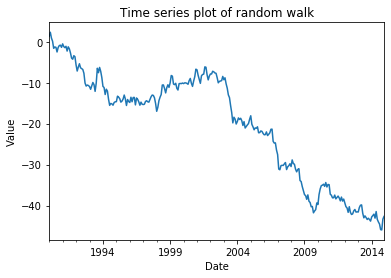

In [9]:
nr.seed(3344)
def ran_walk(start = '1-1990', end = '1-2015', freq = 'M', sd = 1.0, mean = 0):
    dates = pd.date_range(start = start, end = end, freq = freq)
    walk = pd.Series(nr.normal(loc = mean, scale = sd, size = len(dates)),
                    index = dates)
    return(walk.cumsum())
walk = ran_walk()   
plot_ts(walk, 'random walk')

The random walk wanders back and forth, but eventually heads in a particular direction. 

**Your Turn** What does the distribution of values of the random walk look like. What about the ACF and PACF of the random walk? In the cell below, create and execute the code to examine the probability distribution, ACF and PACF of the radom walk. 

Examine these results and answer the following questions:
1. How close to Normally distributed are the values of the random walk? ANS: The values are far from Normmaly distributed    
2. How are the properties of the ACF and PACF different from those of the white noise series? ANS: The ACF dies off very slowly, whereas the PACF has no significant non-zero lag values. 

### White Noise Series with Trend

What happens when we add a trend to the white noise series? Run the code in the cell below which adds a linear trend to a white noise series. 

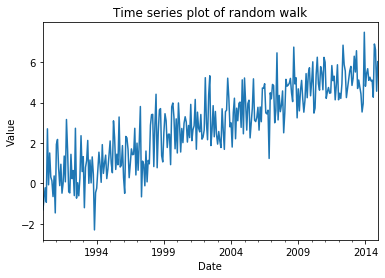

In [10]:
nr.seed(6677)
def trend(start = '1-1990', end = '1-2015', freq = 'M', slope = 0.02, sd = 1.0, mean = 0):
    dates = pd.date_range(start = start, end = end, freq = freq)
    trend = pd.Series([slope*x for x in range(len(dates))],
                    index = dates)
    trend = trend + nr.normal(loc = mean, scale = sd, size = len(dates))
    return(trend)
                              
trends = trend()   
plot_ts(trends, 'random walk')

As expected, the time series trends upward with a linear trend with iid Normal deviations. 

Run the code in the cell below to examine the distribution of values in this time series.

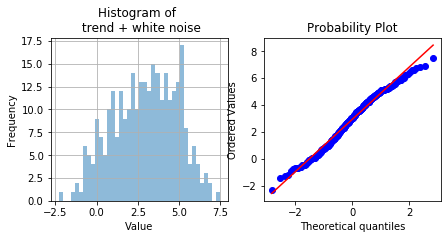

In [11]:
dist_ts(trends, lab = '\n trend + white noise')

The distribution is mostly Normal, but with some skew. You can observe the skew as the 'S' shaped curve in the quantiles valuee.  

How does adding a trend change the ACF and PACF? Run the code in the cell below and examine the results. 

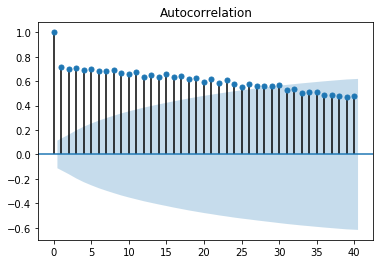

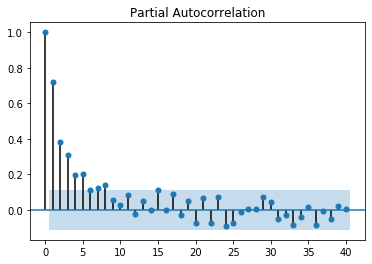

In [12]:
_=splt.plot_acf(trends, lags = 40)
_=splt.plot_pacf(trends, lags = 40)

Note the that the ACF decays slowly, as was the case with the random walk. In additon, the PACF shows significant values for several lags. This is the result of the trend creating dependency from one value to the next. Any time series with a trend is **not stationary**.

### Time Series with a Seasonal Component

Many real-world tine series include a seasonal component. A seasonal component is a period variation in the values of the time series. The periods can be measured in years, months, days, days of the week, hours of the day, etc. Some examples of seasonal components of time series inclde:

- Opion expiration dates in capital markets.
- Annual holidays which can affect transportation, utility use, shopping habits, etc.
- Weekend vs. business days, which account for volumns of certian transaction behavior.
- Month of the year which can affect emploiyment patterns, weather, etc.

Let's investigate the properties of a time series with a seasonal component. The coded in the cell below creates and plots a time series with sinusoidal seasonal component with added White noise. Run this coded and examine the results.

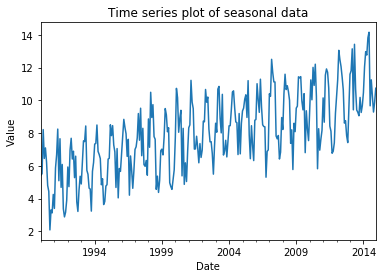

In [13]:
nr.seed(5544)
def seasonal_ts(start = '1-1990', end = '1-2015', freq = 'M', slope = 0.02, sd = 1.0, mean = 0):
    dates = pd.date_range(start = start, end = end, freq = freq)
    seasonal = pd.Series([slope*x for x in range(len(dates))],
                    index = dates)
    seasonal = seasonal + nr.normal(loc = mean, scale = sd, size = len(dates))
    seasonal = seasonal + [2.0*sin(pi*x/6) for x in range(len(dates))] + 5.0
    return(seasonal)

seasonal = seasonal_ts()
plot_ts(seasonal, 'seasonal data')

As expected the time series looks like a noisy sin wave with a trend.

**Your Turn** What does the distribution of values of the seasonal time series look like. What about the ACF and PACF of the sesonal time series? In the cell below, create and execute the code to examine the probability distribution, ACF and PACF of this time series. 

Answer the following questions:

- How close to Normally distributed are the values of the seasonal time series? ANS: The distribution is fairly close to Normal.
- How are the properties of the ACF and PACF different from those of time series you have already examined? ANS: The ACF decays slowly and shows strong periodic behavior and the PACF dies off realitively quickly and exhibits some periodic behavior. 

## Decomposition of Time Series

We have looked at the properties of several types of time series. 

- White noise series.
- Random walks.
- White noise series with trend.
- White noise series with seasonal component.

Next, we have to look into methods for decomposing time series data into its **trend, seasonal and residual** components.

### The STL Decomposition Models

A direct decomposition model is know as the **seasonal, trend and residual** or **STL** model. Not too surprisingly this model does the following:

- The trend is removed using a LOESS regression model. 
- The seasonal component is removed using a regression on periodic components.
- The remainder is know as the residual. 

The decomposition can be either **additive** or **multiplicative**. The additive model simply sums the componets and is writen:

$$TS(t) = S(t) + T(t) + R(t)$$

The multiplicative model multiplies the three components. This model is particuarly useful in the common case where the seasonal effect increases in proportional to the trend. We can write this  model as follows which is transforms to an addative model by a log transformation:  

$$TS(t) = S(t)\ *\ T(t)\ *\ R(t)\\
or\\
log(TS(t)) = S(t) + T(t) + R(t)$$

You can find details of this model in [Rob Hyndman's lecture notes](http://robjhyndman.com/uwafiles/5-Cross-validation.pdf). 

Let's try this out on a time series which has a seasonal, trend and white noise residual component. The code in the cell below models the trend and a monthly seasonal compoent. Run the code to compuute the model.

               resid     trend  seasonal
1990-01-31       NaN       NaN  0.176526
1990-02-28       NaN       NaN  0.736354
1990-03-31       NaN       NaN  1.951446
1990-04-30       NaN       NaN  1.780959
1990-05-31       NaN       NaN  1.628076
1990-06-30       NaN       NaN  1.142755
1990-07-31 -0.017122  4.990888 -0.179054
1990-08-31  0.530561  4.920451 -1.015747
1990-09-30 -1.266179  4.870383 -1.523592
1990-10-31  0.377256  4.880803 -1.954974
1990-11-30  0.017118  4.872056 -1.766961
1990-12-31  0.376213  4.847891 -0.975786


,resid,trend,seasonal
2014-01-31,-0.806781,11.099456,0.176526
2014-02-28,0.115051,11.192865,0.736354
2014-03-31,-0.307412,11.325513,1.951446
2014-04-30,-0.353034,11.338165,1.780959
2014-05-31,0.865197,11.326752,1.628076
2014-06-30,1.618919,11.396875,1.142755
2014-07-31,NaN,NaN,-0.179054
2014-08-31,NaN,NaN,-1.015747
2014-09-30,NaN,NaN,-1.523592
2014-10-31,NaN,NaN,-1.954974


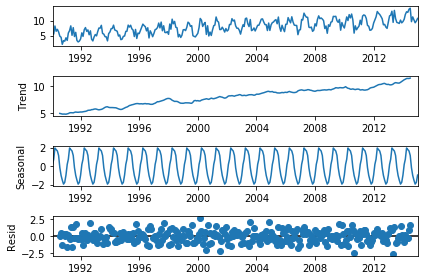

In [14]:
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) #, freq = freq)
    #resplot = res.plot()
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )

decomp = decomp_ts(seasonal)
print(decomp[:12])
decomp[-12:]
#res_mean = res_df.resid.mean()
#if abs(res_mean) > 0.1: res_df.resid = [x - res_mean for x in res_df.resid]

You can see the time series is now decomposed into the three components. Notice that the first and last 6 values of the trend and seasonal component are missing. We will need to take this into account when performing any analysis. 

**Your Turn:** In the cell below create and exectue the code to plot the ACF and PACF of the residual compontent for the STL decomposition.  **Hint**, the residual in the column three of the data frame retured by `ts.decomp`.

Does it appear that the STL process has removed the trend and seasonal components of the time series fully or partially? ANS: The ACF and PACF both decay rather rapidly, but  

## ARIMA Models for the Residual Series

Now that we have investigated the basic properties of time series and some decomposition methods, let's investigate models for dealing with the residuals.

The class of models we will investigate are known and **autoregressive integrated moving average** or **ARIMA** model. We will work our way through each component of this model in the next few subsections. 

The ARIMA model and its relatives are **linear** in their coefficients. ARIMA models are in effect linear regression models. However, as you will see, ARIMA models are constructed to account for the serial correlations in time series data.  

### Autoregressiive Model

The values of an **autoregrissive** or **AR** time series are determined by a linear combination of the past values. In other words, the AR model accounts for serial correlation in the values of the time series. We can write the value of an autoregressive series of **order p** or **AR(p)** series at time t as:

$$x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} \dots \alpha_p x_{t-p} + w_t\\
where\\
w_t = white\ noise\ at\ time\ t$$

An AR process has the following properties:

- $\rho_0 = 1$ always.
- $p_k = \alpha^k$
- Number of nonzero PACF values = p.

AR models are specifically for **stationary time series**. If the variance is not constant or the trend component has not been removed, AR models will not produce statisfactory results.

The function in the code in the cell below does the following:
1. Defines an ARMA proceess of the specified orders.
2. Tests the stationarity and invertability (stability) of the process.
3. Returns Pandas series with samples generated from the ARMA process. Note that the `generate_sample` funtion adds white noise with standard deviation of 1.0 unless otherwise specified. 

Run the code in the cell below which simulates and plots an AR(2), or $x_t = 0.75\ x_{t-1} = 0.25\ x_{t-2}$, model.

In [15]:
nr.seed(4477)
def ARMA_model(ar_coef, ma_coef, start = '1-2005', end = '1-2015'):
    dates = pd.date_range(start = start, end = end, freq = 'M')
    ts = arima.ArmaProcess(ar_coef, ma_coef)
    print('Is the time series stationary? ' + str(ts.isstationary))
    print('Is the time series invertable? ' + str(ts.isinvertible))
    return(pd.Series(ts.generate_sample(120), index = dates))
ts_series_ar2 = ARMA_model(ar_coef = [1, .75, .25], ma_coef = [1])

Is the time series stationary? True
Is the time series invertable? True


Notice that we have applied some tests to determine if our choice of $AR(2)$ coefficients are stable. 

Next, let's create a plot of this time series and have a look at the results. Execute the code in the cell below.

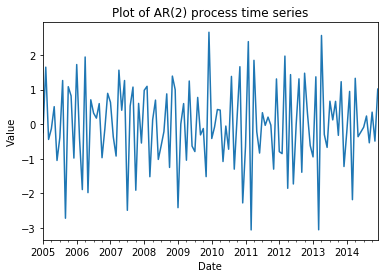

In [16]:
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
plot_ts(ts_series_ar2, title = 'Plot of AR(2) process time series')

The values of this time series look fairly random. The series shows significant deviatiions from the zero, but has no trend. 

The question now is, what are the statistical properties of this $AR(2)$ process? Run the code in the cell below to plot the ACF and PACF of the AR(1) series. 

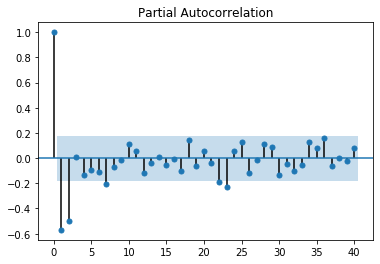

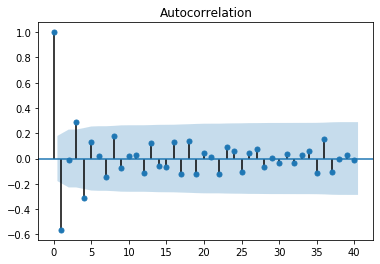

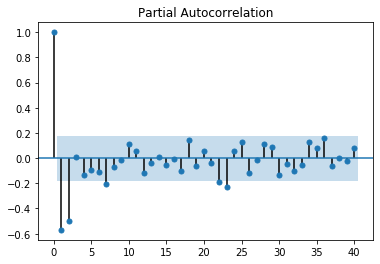

In [17]:
splt.plot_acf(ts_series_ar2, lags = 40)
splt.plot_pacf(ts_series_ar2, lags = 40)

The AR(2) process produces a series with significant correlations in the lags, as shown in the  ACF plot. More importantly, the PACF has 2 significant non-zero lag values, consistent  with an AR(2) model. 

The AR time series model estimates the coeficients for the order of the model specified. The code in the cell below does the following:
1. Uses the `ARIMA` function from the `statsmodels` package to define model. The order of  the AR model is specified as `(p,0,0)`.
2. Fits the coefficient values using the `fit` method on the model object.
3. Prints the output of the `summary` method, showing useful statistics to understand the model.  

Run this code and examine  the  properties of the  results. 

In [18]:
def model_ARIMA(ts, order):
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    print(model_fit.summary())
    return(model_fit)
ar2_model = model_ARIMA(ts_series_ar2, order = (2,0,0))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 0)   Log Likelihood                -152.786
Method:                           mle   S.D. of innovations              0.861
Date:                Fri, 28 Feb 2020   AIC                            311.573
Time:                        15:59:14   BIC                            319.935
Sample:                    01-31-2005   HQIC                           314.969
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.8407      0.080    -10.574      0.000      -0.997      -0.685
ar.L2.y       -0.4881      0.080     -6.136      0.000      -0.644      -0.332
                                    Roots           

Note the following about the AR model:

- The estimated AR coefficients have values farily close to the values used to generate the data. Further, true values are within the standard errors and confidence intervals of the estimated coefficients. Notice negative sign of the coefficient values. 
- The p-values are small and standard error ranges do not include 0 so the coeffieint values are significant. 

### Moving Average Model

For a **moving average** or **MA** model the value of the time series at time `t` is determined by a linear combination of past white noise terms. In other words, the MA model accounts for series correlation in the noise terms. We can write the MA(q) model as the linear combination of the last `q` white noise terms $w_i$:

$$x_t = w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} + \cdots + \beta_q w_{t-q}$$

An MA process has the following properties:

- $\rho_0 = 1$ always.
- Number of nonzero $\rho_k; k \ne 0$ values = q.

MA models are specifically for **stationary time series**. If the variance is not constant or the trend component has not been removed, MA models will not produce statisfactory results.

The code in the cell below computes an `MA(1)` model with a coeficient $\beta_1 = 0.75$, and plots the results. Run this code and examine the plot.

Is the time series stationary? True
Is the time series invertable? True


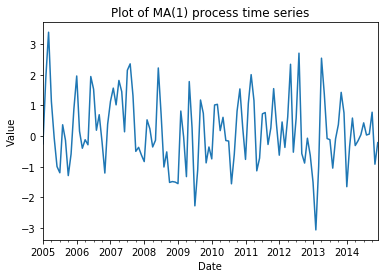

In [19]:
ts_series_ma1 = ARMA_model(ar_coef = [1], ma_coef = [1, .75])
plot_ts(ts_series_ma1, title = 'Plot of MA(1) process time series')

The time series of the MA(1) process looks fairly random, with no trend. 

Next, execute the code in the cell below to plot the ACF and PACF of the MA(1) process. 

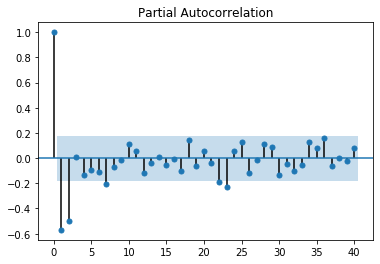

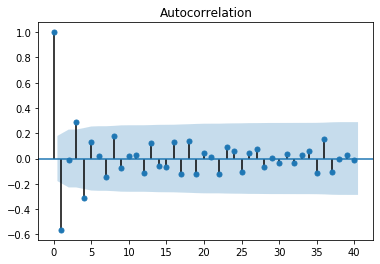

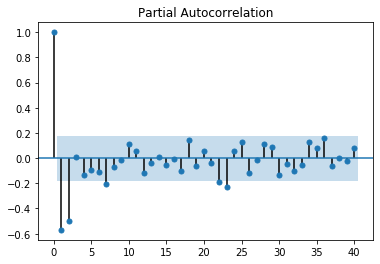

In [20]:
splt.plot_acf(ts_series_ar2, lags = 40)
splt.plot_pacf(ts_series_ar2, lags = 40)

The ACF exhibits only one non-zero lag, which is expected for an MA(1) process. There are also some significant non-zero lags in the PACF, which is a result of random noise.  

Let's try to estimate the coefficients of the MA time series. The code in the cell below fits and MA(1) model to the time series. The model is specified as `(0,0,q)`. Execute this code and examine the result. 

In [21]:
ma1_model = model_ARIMA(ts_series_ma1, order = (0,0,1))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(0, 1)   Log Likelihood                -160.089
Method:                           mle   S.D. of innovations              0.908
Date:                Fri, 28 Feb 2020   AIC                            324.179
Time:                        15:59:16   BIC                            329.754
Sample:                    01-31-2005   HQIC                           326.443
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.9690      0.026     37.493      0.000       0.918       1.020
                                    Roots                                    
                  Real          Imaginary           M

Note the following about the AR model:

- The estimated MA coefficient has a value farily close to the value used to generate the data. Further, true value is within the standard error and confidence intervals of the estimated coefficient. 
- The p-values are small and standard error ranges do not include 0 so the coeffieint values are significant. 

### The Autoregressive Moving Average Model

We can combine the AR and MA models to create an **autoregressive moving averate** or **ARMA** model. This model accounts for serial correlation in both noise terms and values. We would expect we can write an ARMA model of order `(p,q)` as:

$$x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} \dots \alpha_p x_{t-p} +\\
w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} + \cdots + \beta_q w_{t-q}$$

The code in the cell below simulates and plots an `ARMA(1,1)` model. The model is specified by  `(p,0,q)`. Execute this code and examine the results. 

Is the time series stationary? True
Is the time series invertable? True


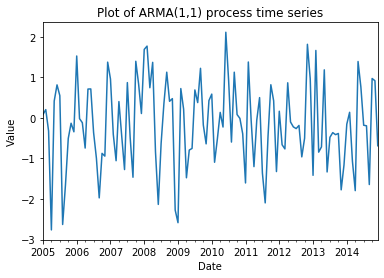

In [22]:
ts_series_arma11 = ARMA_model(ar_coef = [1, .6], ma_coef = [1, .75])
plot_ts(ts_series_arma11, title = 'Plot of ARMA(1,1) process time series')

As expected, the ARMA(1,1) series has properties of both an AR(1) and MA(1) series. 

**Your Turn:** Try estimating the parameters of the time series, printing a summary of the model and plot the ACF and PACF of the residual. **Hint**, the ARMA(1,1) model is specified as `order = (1,0,1)`.  

Run your code, examine the results and answer these questions: 

- How do the estimated MA and AR coefficients compare to the orginal model? ANS: The estimated parameter values are close to the values used to generate the time series. 
- How do the standard errors of the coefficients compare to the magnitudes of the coefficients? ANS: The standard error is small compared to the coefficient values.
- Do the p-values and confidence intervals indicate the coefficients are significant. ANS: Yes, the p-values are small and the confidence intervals do not contain 0. 

### Autoregressive Integrated Moving Average Model

The **autoregreessive integrated moving average**, or **ARIMA** model adds an integrating term to the ARMA model. The integrating component performs differencing to model a random walk component. The integrating component models one of the **non-stationary** parts of a time series. The ARIMA model is defined by orders p, d, q. We have already looked at AR(p) and MA(q) models. The order of the differencing operator of the integrating term is defined by `d`. Since the integrating term is a differencing operator, there is no coeficient to estimate. 

In a pervious section we have already simulated a randomw walk series, and investigated its properties. The code in the cell below uses the Pandas `diff` method to perform first order differencing on the time series. This operation is an ARIMA(0,1,0) model. Execute this code and examine the plotted results. 

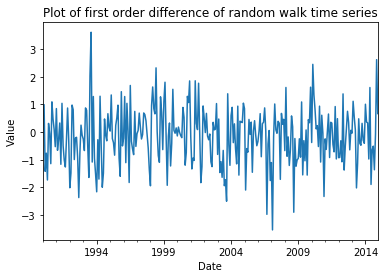

In [23]:
walk_diff = walk.diff()
plot_ts(walk_diff, title = 'Plot of first order difference of random walk time series')

The random walk has been transformed. The time series does not wander any more.

**Your turn:** The question is what are the statistical properties of the remainder series are after the ARIMA(0,1,0) has been applied. Plot the distribution properties, the ACF and PACF of the remainder. **Hint:** You will need to remove the first value from the difference series since the difference operator cannot work on the first element of a time series. 

Examine your results and answer the following questions:
1. Are the values close to Normally distributed? ANS: Yes, the histogram and the q-q Normal plot both show close to Normal behavior. 
2. Are there any significant non-zero lag values in the ACF and PACF and what does this indicate. ANS: No, there are no significant non-zero lag values in either the ACF and PACF, indicating the remainder series is white noise. 

## Real Data Example

Let's apply the models we have been working with on some real-world data. We will work with a data set which shows the consumpton of chocolate, beer and electricity in Australia from 1958 to 1991. 

### Load and Examine the Data

As a first step, run the code in the cell below to load the data from the `.csv` file, add a time series index and examine the head and tail of the data frame. 

In [24]:
CBE = pd.read_csv('cbe.csv')
CBE.index = pd.date_range(start = '1-1-1958', end = '12-31-1990', freq = 'M')
print(CBE.head())
print(CBE.tail())

            choc  beer  elec
1958-01-31  1451  96.3  1497
1958-02-28  2037  84.4  1463
1958-03-31  2477  91.2  1648
1958-04-30  2785  81.9  1595
1958-05-31  2994  80.5  1777
            choc   beer   elec
1990-08-31  8715  148.3  14338
1990-09-30  8450  133.5  12867
1990-10-31  9085  193.8  12761
1990-11-30  8350  208.4  12449
1990-12-31  7080  197.0  12658


As a next step we plot the three time series. Execute the code in the cell below to create these plots. 

Text(0.5, 1.0, 'Three Australian production time series')

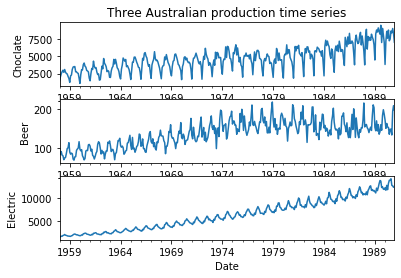

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
CBE.choc.plot(ax = ax1)
CBE.beer.plot(ax = ax2)
CBE.elec.plot(ax = ax3)
ax1.set_ylabel('Choclate')
ax2.set_ylabel('Beer')
ax3.set_ylabel('Electric')
ax3.set_xlabel('Date')
ax1.set_title('Three Australian production time series')

Notice that for each of these time series the amplitude of the seasonal variation grows with time. This is a common situation with real world data. Seeing this situation indicates that we should use a **multiplicative decomposition model**.  

The multiplcative model can be easily transformed to an addative model by taking the logarithm of the values. The code in the cell below performs the log transformation and plots the result for the electric consumption time series. Execute this code and  examine the results.    

Index(['choc', 'beer', 'elec', 'elec_log'], dtype='object')

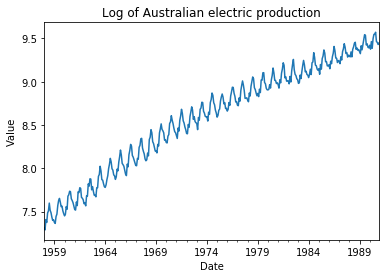

In [26]:
CBE['elec_log'] = np.log(CBE.elec)
plot_ts(CBE.elec_log, 'Log of Australian electric production')
CBE.columns

Notive the follwing properties about this time series.
- It has a a significant trend.
- The time series have a noticable seasonal component.
- The magnitude of the seasonal component increases with trend in the un-transformed time series. 
- The seasonal component of the log transformeed series has a nearly constant magnitude, but decreases a bit with time. 

These results indicate that an STL decomposition is required. Further, a multiplicative (log transformed) STL model is preferred. 

### STL Decomposition of Electric Time Series

Lets do some analysis of the electric time series. In this case, we will use a **multiplicative model** since the magnitude of the seasonal component generally increases with incresing trend. 

Execute the code in the cell below to compute the STL decomposition of the time series and examine the  results.

               resid     trend  seasonal
1958-01-31       NaN       NaN -0.092045
1958-02-28       NaN       NaN -0.111615
1958-03-31       NaN       NaN -0.026562
1958-04-30       NaN       NaN -0.059435
1958-05-31       NaN       NaN  0.054249
1958-06-30       NaN       NaN  0.086016
1958-07-31  0.013179  7.437306  0.147414
1958-08-31 -0.035637  7.443126  0.107311
1958-09-30  0.024762  7.447767  0.015765
1958-10-31 -0.014102  7.453288 -0.001391
1958-11-30 -0.013019  7.460866 -0.049673
1958-12-31  0.006184  7.469344 -0.070032
               resid     trend  seasonal
1990-01-31  0.061058  9.451265 -0.092045
1990-02-28  0.033966  9.452911 -0.111615
1990-03-31  0.033789  9.455971 -0.026562
1990-04-30 -0.012603  9.458263 -0.059435
1990-05-31 -0.018648  9.460369  0.054249
1990-06-30 -0.004134  9.464073  0.086016
1990-07-31       NaN       NaN  0.147414
1990-08-31       NaN       NaN  0.107311
1990-09-30       NaN       NaN  0.015765
1990-10-31       NaN       NaN -0.001391
1990-11-30      

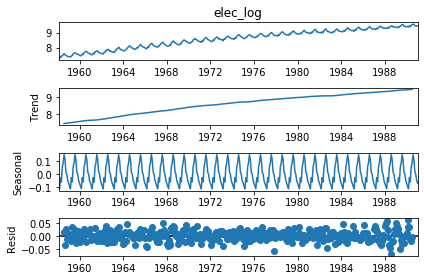

In [27]:
elect_decomp = decomp_ts(CBE.elec_log)
print(elect_decomp.head(12))
print(elect_decomp.tail(12))

Note the following about these results:

- The periodic component looks reasonable, but may not be stationary as evidenced by the remainder.
- The removal of the trend component appears to be satisfactory.

We can apply the **Dicky Fuller test** to determine if the residual is stationary. The null hyposesis is that the time series is not stationary, but with no trend. 

The code in the cell below executes the DF test and prints some summary statistics. Notice that the first and last 6 elements of the must be filtered, since they have `nan` values. Execute this code and examine the results.  

In [28]:
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
DF_Test(decomp.resid[6:-6])    

D-F statistic = -7.967614947738874
p-value = 2.8370738272850173e-12
number of lags used = 16
Critical value at 5% confidence = -2.8722649771800155
Critical value at 10% confidence = -2.5724850011573914


Given the DF statistic and p-value we can reject the null hypothesis that the residual is not stationary. 

As a next step, compute and plot the ACF and PACF for the remainder series.

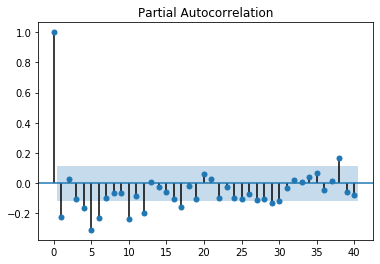

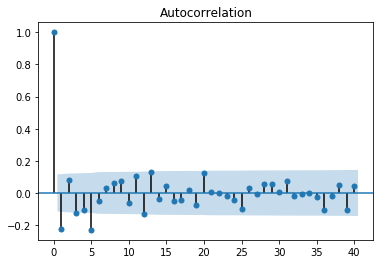

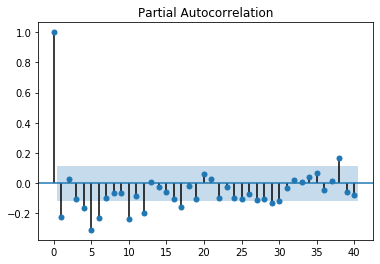

In [29]:
splt.plot_acf(decomp.resid[6:-6], lags = 40)
splt.plot_pacf(decomp.resid[6:-6], lags = 40)

The ACF and PACF exhibit both AR and MA behavior. However, there are signs of periodicity which the STL decomposition has not removed. 

### Apply ARIMA Model

Now that we have an STL decomposition of the electric use time series, we can compute an ARIMA model for the residual. As a starting point we will use an ARIMA(2,1,2) model. Run the code in the cell below and examine the results.

In [30]:
arima_electric = model_ARIMA(decomp.resid[6:-6], order = (2,1,1))

                             ARIMA Model Results                              
Dep. Variable:                D.resid   No. Observations:                  287
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -373.414
Method:                           mle   S.D. of innovations              0.880
Date:                Fri, 28 Feb 2020   AIC                            754.829
Time:                        15:59:20   BIC                            769.467
Sample:                    08-31-1990   HQIC                           760.696
                         - 06-30-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.resid    -0.2132      0.059     -3.586      0.000      -0.330      -0.097
ar.L2.D.resid     0.0325      0.059      0.547      0.584      -0.084       0.149
ma.L1.D.resid    -1.0000      0.009   -1

The standard error of the second AR coefficient is similar in magnitude or larger than the coefficient themselve. Further, the confidence interval overlaps zero. This behavior indicates that the model is over fit or over parameterized.

Now, the question is, how do we find the 'best' ARIMA model for the residual? We need a criteria to compare models with different values of p, d and q. 

The **Baysian Information Criteria** or **BIC** is closely related to the Akaike Information Criteria. The BIC was proposed by Gideon Schwarz in 1978, and is sometimes referred to as the Schwarz Information Criteria. The BIC weights the number of parameters in the model by the log of the number of observations. We can write the BIC as:

$$BIC = ln(n)\ k- 2\ ln(\hat{L})\\
where\\
\hat{L} = the\ likelihood\ given\ the\ fitted\ model\ parmaters\ \hat\theta = p(x| \hat\theta)\\
x = observed\ data\\
k = number\ of\ model\ parameters\\
n = number\ of\ observations$$

The code in the iterates over a grid of p, d and q values. For each p, d, q combination the BIC is computed and compared to the best previous model. In a bit more detail the function in the cell below does the following:
1. Initialize a large value of BIC. 
2. Iterate over the grid of specified p, d and q.
3. Compute an ARIMA model of order (p,d,q). This process is wrapped in a `try` to prevent the function from crashing if the model is unstable and does not converge. 
4. The BIC of each model is compared to the best (lowest) BIC found so far. If a better model is found, that model, its parameters, and the BIC are saved as the best model.
5. Once the loop has completed the best BIC, the order of the best model and the best model are all returned. 

Execute the code and examine the results. 

In [42]:
Log_electric = CBE.elec_log[:'1989-12-31']
Log_electric.tail(12)

1989-01-31    9.348797
1989-02-28    9.323490
1989-03-31    9.414505
1989-04-30    9.367686
1989-05-31    9.426983
1989-06-30    9.492432
1989-07-31    9.542876
1989-08-31    9.535246
1989-09-30    9.424403
1989-10-31    9.437157
1989-11-30    9.395824
1989-12-31    9.390743
Freq: M, Name: elec_log, dtype: float64

In [38]:
best_model = pm.auto_arima(Log_electric, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-1808.202, BIC=-1788.621, Time=4.121 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-1573.987, BIC=-1566.154, Time=0.072 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-1706.094, BIC=-1690.429, Time=1.486 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-1810.351, BIC=-1794.686, Time=1.821 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=-1575.980, BIC=-1572.064, Time=0.055 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=-1704.947, BIC=-1693.198, Time=0.400 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-1805.123, BIC=-1785.542, Time=2.017 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=-1786.851, BIC=-1767.270, Time=3.413 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circ

In [39]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 909.175
Date:                            Fri, 28 Feb 2020   AIC                          -1810.351
Time:                                    16:14:29   BIC                          -1794.686
Sample:                                         0   HQIC                         -1804.129
                                            - 384                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.269e-05      0.000     -0.786      0.432      -0.000       0.000
ma.L1         -0.6802      0.038    -17.826      0.000      -0.755      -0.605
ma.S.L12      -0.6950      0.047    -14.886      0.000      -0.787      -0.603
sigma2         0.0004   2.77e-05     15.364      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       72.20   Jarque-Bera (JB):                 9.28
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.95   Skew:                            -0.21
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
def model_ARIMA_2(ts, order):   
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    BIC = ARIMAResults.bic(model_fit)
    print('Testing model of order: ' + str(order) + ' with BIC = ' + str(BIC))
    return(BIC, order, model_fit)

def step_ARIMA(resid, p_max, d_max, q_max):
    best_BIC = 9999999999999999.0
    for p in range(p_max + 1):
        for d in range(d_max + 1):
            for q in range(q_max + 1):
                if(p > 0 or q > 0):
                    try:
                        order = (p, d, q)
                        BIC, order, model = model_ARIMA_2(resid, order)
                        if(BIC < best_BIC):
                            best_model = model
                            best_BIC = BIC
                            best_order = order
                    except: 
                        pass        
    return(best_BIC, best_order, best_model) 

#BIC, order, model = step_ARIMA(decomp.resid[6:-6], 3, 3, 3)    
#print('***************************************')
#print('Best model with BIC = ' + str(BIC) + ' and with order '+ str(order))

Examine the results above. You can see how the interation over the model order eventually converged to a model with the smallest BIC. 

**Your turn:** Having found an apparent best model order, but how well does this model fit the residuals? And, is the model actually invertable (stable)? In the cell below compute and print a summary of a model of the best order. 

Examine these result. Do all the coefficients appear to be significant, or is one coefficient of marginal significance, and if so which one? ANS: The second AR coefficient is of marginal significance. 

## Forecasting Time Series

Now that we have explored these data, the next step is to compute and evaluate a forecast model. In this case, we will hold back the last 12 months of data before we train the model. The final 12 months of data can then be used to evaluate the model. 

We will train the model in three steps:
1. Compute new features, the count of months from the start of the time series and the square of count of months. These features are used to model trend.
2. Normalize these numeric features.
3. Create new dummy (binary) variables for the months. These features are used to model the seasonal variation.
4. Coeffients for the trend and seasonal features are computed using a linear regression model.
5. An ARIMA model for the residuals is computed. 
6. A prediction of the electric produciton is made for a 12 month period using the trend, seasonal and residual models.

The code in the cell below performs the first three steps of the process. Execute this code and examine the results.

In [46]:
prediction = pd.Series(best_model.predict(n_periods=12), 
                       index = pd.date_range(start = '1990-01-31', end = '1990-12-31', freq = 'M'))
prediction

1990-01-31    9.389736
1990-02-28    9.365810
1990-03-31    9.446900
1990-04-30    9.400035
1990-05-31    9.486184
1990-06-30    9.529750
1990-07-31    9.588175
1990-08-31    9.565601
1990-09-30    9.473204
1990-10-31    9.480471
1990-11-30    9.439307
1990-12-31    9.443739
Freq: M, dtype: float64

Examine the new features in the data frame. You can see the features for modeling the trend and the dummy variables for the seasonal variation.

The code in the cell below computes a linear model for coefficients of the trend and seasonal features. The steps are:

1. The features are extracted into a numpy array.
2. The lable is extracted into a numpy array.
3. The model is defined. Note that we do no use an intercept since we have the seasonal component, which is categorical feature. 
4. The model fit is computed.
5. Predictions of the trend and seasonal values are computed.
6. The residuals with respect to these predictions are computed. 

Execute this code.   

Text(0.5, 0, 'Date')

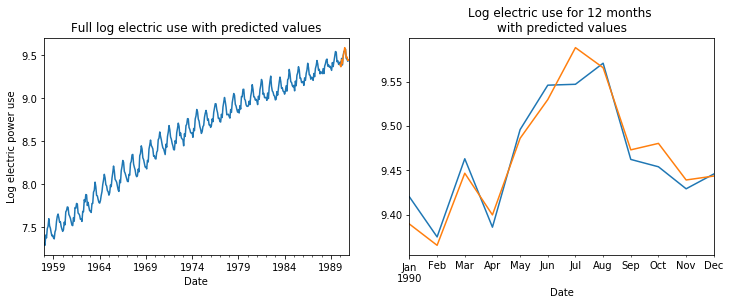

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
CBE.elec_log.plot(ax=ax[0])
prediction.plot(ax=ax[0])
ax[0].set_title('Full log electric use with predicted values')
ax[0].set_ylabel('Log electric power use')
ax[0].set_xlabel('Date')

CBE.elec_log['1990-01-31':].plot(ax=ax[1])
prediction.plot(ax=ax[1])
ax[1].set_title('Log electric use for 12 months \nwith predicted values')
ax[1].set_xlabel('Date')


In [60]:
residuals = CBE.elec_log['1990-01-31':] - prediction
print(residuals)
print('\nThe STD of the residuals = {}'.format(np.round(np.std(residuals), 3)))

1990-01-31    0.030541
1990-02-28    0.009452
1990-03-31    0.016298
1990-04-30   -0.013810
1990-05-31    0.009786
1990-06-30    0.016205
1990-07-31   -0.041220
1990-08-31    0.005068
1990-09-30   -0.010783
1990-10-31   -0.026322
1990-11-30   -0.009911
1990-12-31    0.002306
Freq: M, dtype: float64

The STD of the residuals = 0.019


Let's have a look at how these predicted trend and seasonal components fit the actual electric production time series. The code in the cell below plots the actual time series in red and the values predicted by the trend and seasonal model in blue. Execute the code in the cell below and examine the results. 

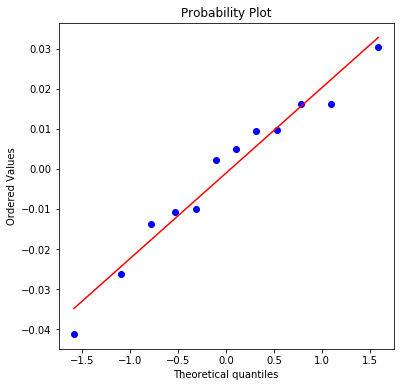

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
_=ss.probplot(residuals, plot = ax)

You can see that the trend and seasonal components fit the actaul data fairly well. 

To have a point of comparison, exectute the code in the cell below to compute the **root mean square error (RMSE)** of the fit of the model for the last 12 months of the electric production time series. 

Next, let's have a look at a time series plot and distribution plots of the residuals. Execute the code in the cell below and examine the results. 

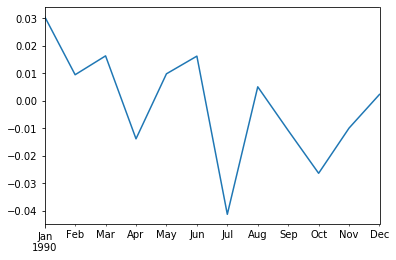

In [72]:
residuals.plot()

The time series plot of the residual shows some minor periodic behavior. The distribution plots show the values to be close to Normally distributed. 

One other question we can ask is if the residual series is stationary. The code in the cell below applys the Dicky Fuller test. Execute this code and examine the results. 

In [37]:
DF_Test(CBE.loc[:'1989-12-31', 'resids'])

D-F statistic = -2.8196478588689184
p-value = 0.05552155739405212
number of lags used = 15
Critical value at 5% confidence = -2.8694261442901396
Critical value at 10% confidence = -2.5709711770439507


Notice that the results are marginal. We cannot reject the null hypotheis (the time series is not stationary) at the 95% confidence level, but can at the 90% confidence level. This should not be too surprising, give the periodic behavor seen in the time series plot. 

Now, we will compute an ARIMA model for the residual usig the `step_ARIMA` function we used earlier. We will train this model, without the last 12 months of data, which we will use to evaluate the model. Execute the code in the cell below to search for the best ARIMA mode order. 

In [38]:
BIC, order, model_fit = step_ARIMA(CBE.loc[:'1989-12-31', 'resids'], 4, 3, 4)    
print('Best order = ' + str(order) + ' best BIC = ' + str(BIC))

Testing model of order: (0, 0, 1) with BIC = -1735.0022594935247
Testing model of order: (0, 0, 2) with BIC = -1784.8093755105592
Testing model of order: (0, 0, 3) with BIC = -1819.919657023036
Testing model of order: (0, 0, 4) with BIC = -1829.8799132298848
Testing model of order: (0, 1, 1) with BIC = -1844.2166017000502
Testing model of order: (0, 1, 2) with BIC = -1842.9835827076793
Testing model of order: (0, 1, 3) with BIC = -1847.889003464537
Testing model of order: (0, 1, 4) with BIC = -1852.3516178067348
Testing model of order: (0, 2, 1) with BIC = -1766.3444495940475
Testing model of order: (1, 0, 0) with BIC = -1844.01931364813
Testing model of order: (1, 0, 1) with BIC = -1863.0346044038583
Testing model of order: (1, 0, 2) with BIC = -1857.842362623
Testing model of order: (1, 0, 3) with BIC = -1852.130660320696
Testing model of order: (1, 0, 4) with BIC = -1855.3038462144016
Testing model of order: (1, 1, 0) with BIC = -1832.4292124687347
Testing model of order: (1, 1, 1) 

C:\Users\StevePC2\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\StevePC2\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Testing model of order: (2, 1, 3) with BIC = -1896.3201340692747
Testing model of order: (2, 1, 4) with BIC = -1890.4011341798684
Testing model of order: (2, 2, 0) with BIC = -1671.7754346534725
Testing model of order: (3, 0, 0) with BIC = -1858.066104182165
Testing model of order: (3, 0, 1) with BIC = -1858.200226189582
Testing model of order: (3, 0, 2) with BIC = -1852.2589897145274


C:\Users\StevePC2\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (3, 0, 3) with BIC = -1890.4790311319152


C:\Users\StevePC2\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (3, 0, 4) with BIC = -1846.9064382481124
Testing model of order: (3, 1, 0) with BIC = -1828.8744952171755
Testing model of order: (3, 1, 1) with BIC = -1849.3990048517262
Testing model of order: (3, 1, 2) with BIC = -1843.6262975480506
Testing model of order: (3, 1, 3) with BIC = -1846.5015525282245
Testing model of order: (3, 1, 4) with BIC = -1886.0978656530274
Testing model of order: (3, 2, 0) with BIC = -1696.735397651542
Testing model of order: (4, 0, 0) with BIC = -1852.678584895553
Testing model of order: (4, 0, 1) with BIC = -1852.2755148300728
Testing model of order: (4, 0, 2) with BIC = -1846.5156937085212
Testing model of order: (4, 0, 3) with BIC = -1849.4068592887938
Testing model of order: (4, 0, 4) with BIC = -1858.60345410999
Testing model of order: (4, 1, 0) with BIC = -1825.7275010934318
Testing model of order: (4, 1, 1) with BIC = -1849.6624641167157
Testing model of order: (4, 1, 2) with BIC = -1879.736663753841
Testing model of order: (4, 1,

C:\Users\StevePC2\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (4, 1, 4) with BIC = -1880.2655466425317
Testing model of order: (4, 2, 0) with BIC = -1703.8354202900068
Best order = (2, 1, 3) best BIC = -1896.3201340692747


Now that we have tested a wide range of models we will test the model. Execute the code in the cell below to compute an ARIMA model of order $(3,0,3)$.

In [39]:
arima_remainder = model_ARIMA(CBE.loc[:'1989-12-31', 'resids'], order = (3,0,3))

                              ARMA Model Results                              
Dep. Variable:                 resids   No. Observations:                  384
Model:                     ARMA(3, 3)   Log Likelihood                 966.067
Method:                           mle   S.D. of innovations              0.019
Date:                Wed, 26 Feb 2020   AIC                          -1918.134
Time:                        17:40:42   BIC                          -1890.479
Sample:                    01-31-1958   HQIC                         -1907.165
                         - 12-31-1989                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.resids     2.7240      0.001   3475.954      0.000       2.722       2.726
ar.L2.resids    -2.7082      0.001  -3441.620      0.000      -2.710      -2.707
ar.L3.resids     0.9841      0.000   9725.15

C:\Users\StevePC2\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Evidently, this high order ($3 + 3 = 6$) model is evidently not stable. Next we will test the next best model, which has a lower order. $(2,0,0)$. Execute the code in the cell below to compute and test this model. 

In [40]:
arima_remainder = model_ARIMA(CBE.loc[:'1989-12-31', 'resids'], order = (2,0,0))

                              ARMA Model Results                              
Dep. Variable:                 resids   No. Observations:                  384
Model:                     ARMA(2, 0)   Log Likelihood                 940.172
Method:                           mle   S.D. of innovations              0.021
Date:                Wed, 26 Feb 2020   AIC                          -1874.343
Time:                        17:40:42   BIC                          -1862.491
Sample:                    01-31-1958   HQIC                         -1869.642
                         - 12-31-1989                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.resids     0.5242      0.049     10.595      0.000       0.427       0.621
ar.L2.resids     0.2498      0.050      5.024      0.000       0.152       0.347
                                    Roots   

This model is stable. Now we can Compute predicted values for the ARIMA model using the 'predict' method. Execute the code in the cell below and examine the results. 

In [41]:
## Predictions from the order model
start_index = len(CBE.loc[:'1989-12-31', 'resids']) - 1
end_index = start_index + 12
model_prediction = arima_remainder.predict(start=start_index, end=end_index)
model_prediction

1989-12-31   -0.041686
1990-01-31   -0.049426
1990-02-28   -0.042885
1990-03-31   -0.034828
1990-04-30   -0.028970
1990-05-31   -0.023887
1990-06-30   -0.019759
1990-07-31   -0.016325
1990-08-31   -0.013494
1990-09-30   -0.011152
1990-10-31   -0.009217
1990-11-30   -0.007617
1990-12-31   -0.006295
Freq: M, dtype: float64

We are now ready to compute the prediction for the last 12 months of the log of the electric production time series. The prediction is the combination of the trend, seasonal and residual (ARIMA) model, acconting for sign differences. The code in the cell below computes this prediction. Execute this code to compute the prediction. 

In [42]:
## Make the forecast for the next year
X = CBE.loc['1989-12-31':, ['Month_Cnt', 'Month_Cnt2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
## and the predictions for the forecast
CBE.loc['1989-12-31':, 'scores'] =  mod_fit.predict(X) - model_prediction

C:\Users\StevePC2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Next execute the code in the cell below to plot the actual time series (in red) and the prediction (in blue). 

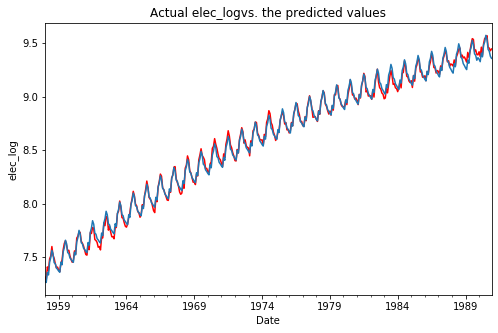

In [43]:
plot_mod_fit(CBE, 'elec_log') 

The forecast looks reasonable. The red, actual time series, and the prediction, in blue, look very similar for the last 12 months. 

Finally, let's compute the RMSE and compare these results to the model with only trend and seasonal component. 

In [44]:
RMSE(CBE.loc['1989-12-31':, 'elec_log'].as_matrix(), CBE.loc['1989-12-31':, 'scores'])

C:\Users\StevePC2\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


0.02766802316341654

The RMSE has improved from 0.033 to 0.028. Adding the ARIMA component to the model has improved the prediction. 

## Models for Non-Stationary Variance.

The **Autoregressive conditional heteroskedasticity** or **ARCH** and **Generalized Autoregressive conditional heteroskedasticity** or **GARCH** model, and their many relatives, are specifically indended to deal with variance which changes with time. Robert Engle published the ARCH model in 1982 for which he was awarded the Nobel Prize in Economics in 2003. 

These models are beyond the scope of this lesson. Additional information can be found in the references given earlier. Software packages for these models are widely available, including in R and Python.  